<a href="https://colab.research.google.com/github/acastellanos-ie/machine_learning_2/blob/master/feature_engineering_practice/Practice%20Proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_url = 'https://github.com/acastellanos-ie/machine_learning_2'

In [ ]:
! git clone $repository_url

Install the requirements

In [ ]:
! pip install -Uqqr machine_learning_2/requirements.txt

Go to the practice directory



In [ ]:
%cd machine_learning_2/feature_engineering_practice

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

The following code includes some imports and configuration steps for better visualization

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

# Introduction

We will first contact the featuring engineering process and its impact in an ML pipeline in this first practice session.
Feature engineering is one of the essential steps of the process of developing prediction models. It is considered, by many authors, an art, and it involves human-driven design and intuition. This practice will try to uncover the most relevant issues that must be addressed and provide some guidelines to start building sound feature engineering processes for ML problems. 

The experimental dataset we are going to use is the HR Analytics Dataset. It includes explanatory variables of around 15k employees of a large company. The goal of the case study is to
model the probability of attrition (employees leaving, either on their own or because they got fired) of each employee and understand which variables are the most important ones and need to be addressed right away.

The results obtained will be helpful for the management to understand what changes they should make to their workplace to get most of their employees to stay.

For more details on the dataset and the task, see <https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression>.

# Data Loading and Pre-Processing

Let's load the dataset to make sense of the information we have about the employees.

In [ ]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
initial_hr_df = pd.read_csv("data/turnover.csv")
initial_hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
# Keep the original dataset for later comparisons and make a copy for the FE process
hr_df = initial_hr_df

We have 10 columns: the target variable (`left`) and 9 more features to work with. Let's analyze a little bit more each of them to check if we need to clean or preprocess them.

At this point I want to provide you with a very handful library to analyze your datasets: `pandas_profiling` (for more information and how to install it, check the official documentation: https://pandas-profiling.github.io/pandas-profiling/docs/). This library will analyze your dataset, taking into account the different aspects you usually want to inspect, and it will create a report that I find very useful to: 1) better understand your data and inform your ML pipeline and 2) to create a visual dataset summary that can be included in your final report.

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(hr_df, minimal=False)
report

## Factorize Features

2 of the categories (`sales` and `salary`) are categorical. In addition, if we analyze the rest of the features we will see that we have three more categorical values encoded as numeric: `Work_accident`, `promotion_last_5years` and the target variable itself (`left`). Therefore, we should convert them to categorical before any further processing.

You can use the `astype` function for the conversion.

In [ ]:
hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [ ]:
hr_df['sales'] = hr_df.sales.astype('category')
hr_df['salary'] = hr_df.salary.astype('category')
hr_df['promotion_last_5years'] = hr_df.promotion_last_5years.astype('category')
hr_df['left'] = hr_df.left.astype('category')
hr_df['Work_accident'] = hr_df.Work_accident.astype('category')

hr_df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                    category
salary                   category
dtype: object

### Advanced Factorization

The rest of the numerical values present a level of detail that may be much more fine-grained than we need. For instance, the satisfaction level can be represented by different categories (low, medium, high, ...). We will then create another "bucketized" feature for each of the numerical columns.

The following piece of code is just a demonstrative example of how to do this process. The values that I've selected for the bucketization are arbitrary. In a real example, you should either find the optimal configuration or rely on some business knowledge to define these values. 


In [ ]:
hr_df['satisfaction_level_bin'] = pd.cut(hr_df['satisfaction_level'], bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0], labels=[0,1,2,3,4,5]).astype('int64')
hr_df['last_evaluation_bin'] = pd.cut(hr_df['last_evaluation'], bins=[0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0], labels=[0,1,2,3,4,5]).astype('int64')


In [ ]:
hr_df['number_project_cat'] = hr_df['number_project'].map({2:"Low",3:"Low",4:"Medium",5:"Medium",6:"High",7:"Very_High"}).astype('category')
hr_df['time_spend_company_cat'] = hr_df['time_spend_company'].map({2:"Low",3:"Medium",4:"Medium",5:"Medium",6:"High",7:"High",8:"Very_High",10:"Very_High"}).astype('category')

## Hunting NAs

There is not any NULL values, so we can skip this step. You can see by summarizing the dataset or you can use the `isnull` function to identify the null values.

In [ ]:
hr_df.isnull().sum()

satisfaction_level        0
last_evaluation           0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
sales                     0
salary                    0
satisfaction_level_bin    0
last_evaluation_bin       0
number_project_cat        0
time_spend_company_cat    0
dtype: int64

It is unlikely not to have any null values in the dataset (this is a reduced and rather clean dataset of the original one). In the case that you have null values, you should follow some of the imputation/removal strategies explained in class. Although `sklearn` (and some other libraries) provides ways to impute/remove the null values while training your model, I strongly recommend you to do it by yourself to control the process.


As we have some categorical values with strings, we need to encode them to apply the sklearn classifiers. There are several ways of performing this encoding step. I do recommend you to check the sklearn documentation for more details.

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

Another helpful resource that you can check with code examples:

https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline.html

Finally, the simplest one (and the one that I will use) is to leverage the [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function in pandas:

In [ ]:
# Concat the dummified columns and the target variable
dummified_hr_df = pd.concat([
        pd.get_dummies(hr_df.drop(['left'], axis=1)).reset_index(drop=True),
        hr_df['left'].reset_index(drop=True)],
    axis=1)
dummified_hr_df.head(5)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,satisfaction_level_bin,last_evaluation_bin,Work_accident_0,Work_accident_1,promotion_last_5years_0,...,salary_medium,number_project_cat_High,number_project_cat_Low,number_project_cat_Medium,number_project_cat_Very_High,time_spend_company_cat_High,time_spend_company_cat_Low,time_spend_company_cat_Medium,time_spend_company_cat_Very_High,left
0,0.38,0.53,2,157,3,2,2,1,0,1,...,0,0,1,0,0,0,0,1,0,1
1,0.80,0.86,5,262,6,4,3,1,0,1,...,1,0,0,1,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,3,1,0,1,...,1,0,0,0,1,0,0,1,0,1
3,0.72,0.87,5,223,5,4,3,1,0,1,...,0,0,0,1,0,0,0,1,0,1
4,0.37,0.52,2,159,3,2,2,1,0,1,...,0,0,1,0,0,0,0,1,0,1


# Train-Test Splitting

Before modifying any futher our dataset, we are going to split the annotated dataset in training and test for the later evaluation of our ML models. 
To that end, sklearn again provides a `train_test_split` function to do it.

It's important that you only use the training set for the feature engineering process. Otherwise, you will be leaking information from the test set (something you should avoid at all costs).  The process is more or less as follows:
- You use the data in the training set to define whatever transformation you want to apply to your dataset.
- You transform your dataset accordingly.
- You do the same transformation for the test set.

In this way, you will guarantee that you are not making any decisions based on the data in your test set.

Now the splitting. I am using 2/3 of the dataset for training and 1/3 for testing. There is no right splitting, but usually, we use more data for training than for test, especially if you do not have so much data.

In the next lab session, we will explore the idea of cross-validation, so this decision will not be so important.

In [ ]:
from sklearn.model_selection import train_test_split

# left is the target variable
X = dummified_hr_df.loc[:, dummified_hr_df.columns != 'left']
y = dummified_hr_df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Outlier Analysis

Another aspect that may affect the performance of our machine learning pipeline is the presence of outliers. We will focus on the numerical columns of the dataset to detect the presence of outliers and proceed to their removal.

The easiest way to detect outliers is by visualizing the numerical values, such as `boxploting` the column values.

For instance, if we plot the `time_spend_company` feature, we will see some extreme cases of employees who have spent many years at the company. 

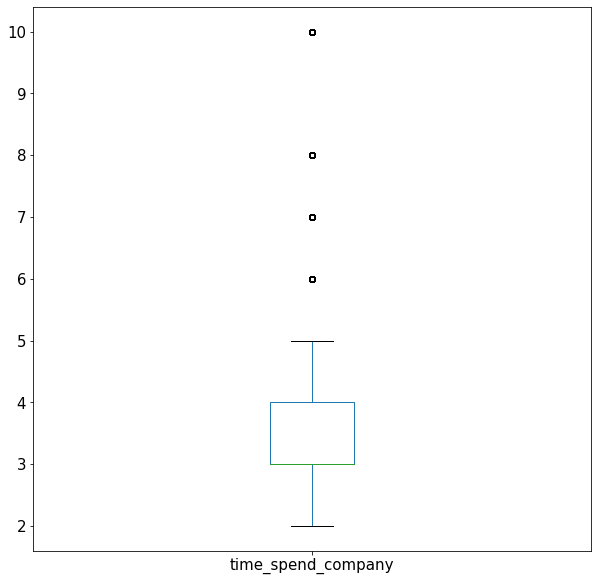

In [ ]:
plt.figure(figsize=(10,10))
X_train.boxplot(['time_spend_company'], grid=False, fontsize=15);


Usually, we don't want these extreme cases to affect or bias the training process; however, we might want to keep them in this case. Are the extreme cases meaningful? Are they related to some type of employee or behavior that we care to track? 

I leave this analysis up to you (and the analysis of the rest of the features), but in the following, I will show you a code example in case you want to remove them. Of course, removal is not the only option. You can also impute these outliers by, for instance, assign to them the average of the feature values.

For the outlier removal, we can apply some metric (i.e., the Z-score) to detect and remove these points. Pandas provides a `quantile` function to compute the different quantiles and to remove the outliers based on them. You can also make use of more advanced techniques, such as Isolation Forest (more details at: https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest). Let's make use of the former to try to remove the outliers.

In [ ]:
# See https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    
def remove_outlier(df_in, col_name, q1 = None, q3= None):
    if q1 is None and q3 is None:
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out, q1, q3

In [ ]:
# Remove the outliers form the training set and returs the quantiles thresholds used for it
X_train, q1, q3 = remove_outlier(X_train, 'time_spend_company')

# Remove the outliers form the test set by using the same quantiles thresholds than in the test set
X_test, _ , _ = remove_outlier(X_test,'time_spend_company', q1, q3)

861 outliers removed
421 outliers removed


Let's do the same for the rest of the columns.

Analyzing outliers of column: satisfaction_level
0 outliers removed
0 outliers removed


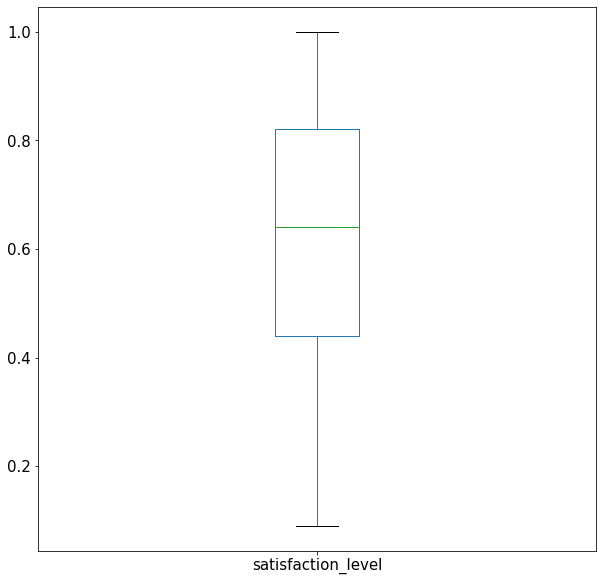

Analyzing outliers of column: last_evaluation
0 outliers removed
0 outliers removed


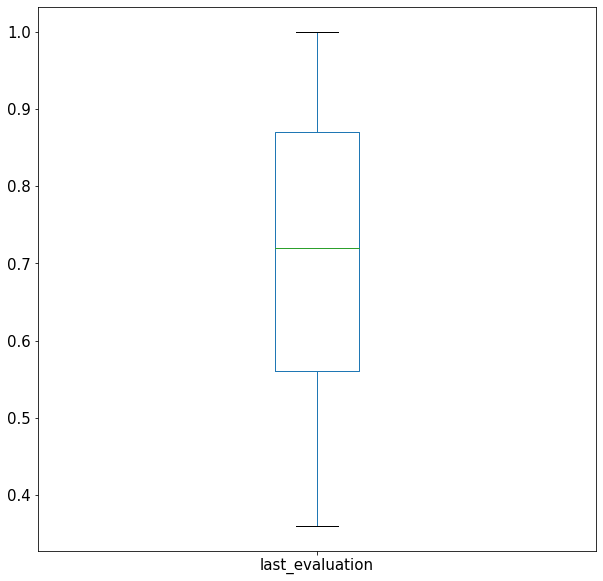

Analyzing outliers of column: number_project
0 outliers removed
0 outliers removed


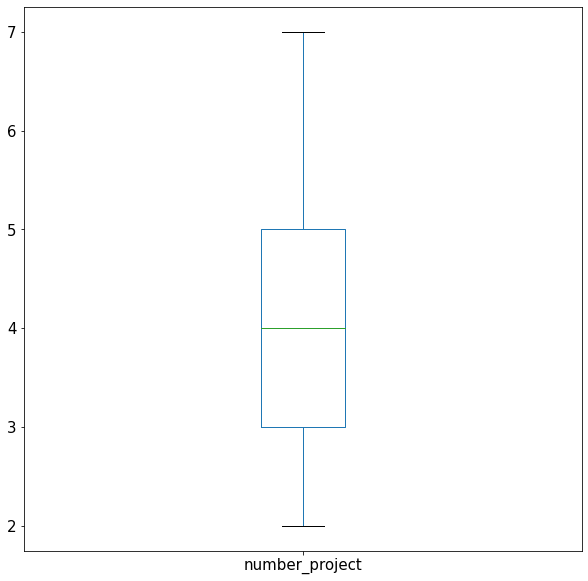

Analyzing outliers of column: average_montly_hours
0 outliers removed
0 outliers removed


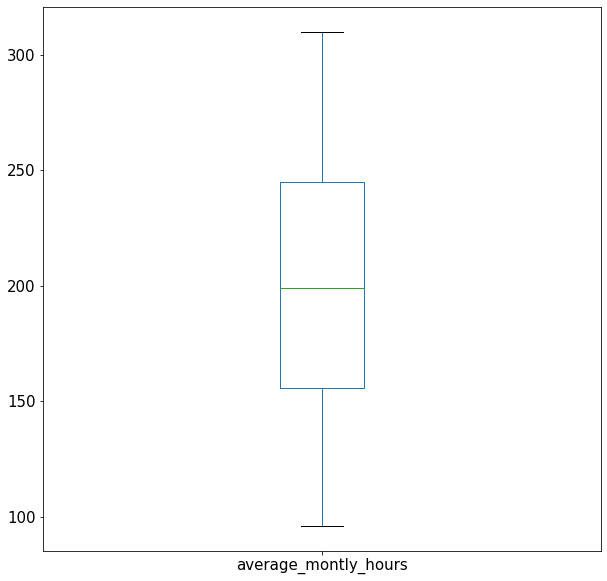

Analyzing outliers of column: time_spend_company
0 outliers removed
0 outliers removed


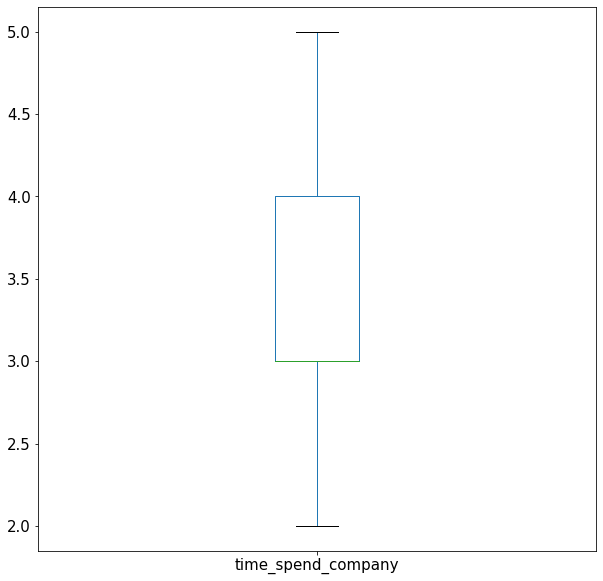

Analyzing outliers of column: satisfaction_level_bin
0 outliers removed
0 outliers removed


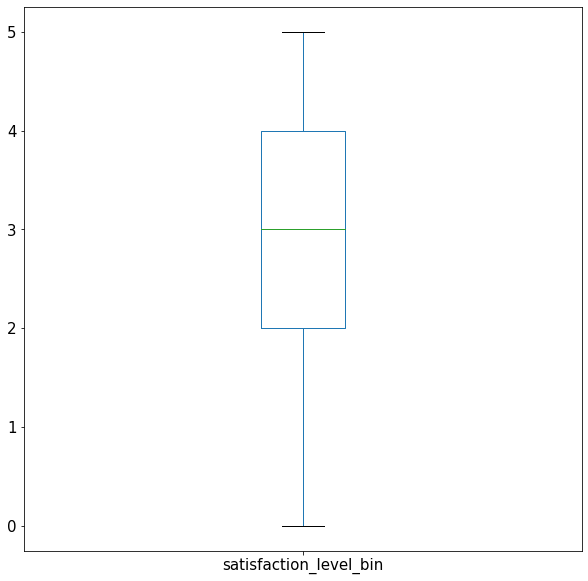

Analyzing outliers of column: last_evaluation_bin
2390 outliers removed
1150 outliers removed


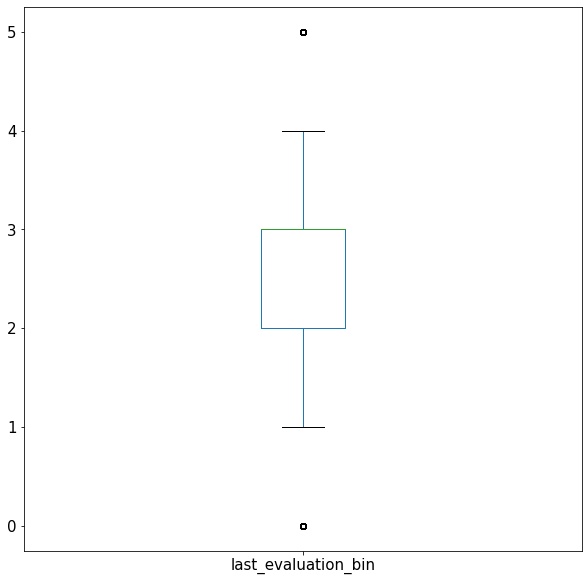

In [ ]:
for (columnName, _) in X_train.iteritems():
    if X_train[columnName].dtype in ['int64','float64']: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        X_train.boxplot([columnName], grid=False, fontsize=15)
        X_train, q1, q3 = remove_outlier(X_train, columnName)
        X_test, _, _ = remove_outlier(X_test, columnName, q1, q3)
        plt.show()
    
# We keep only the labels related to the training and test samples that remain after the outlier process.
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

This way of identifying and removing the outliers is entirely manual.

There are many procedures and libraries to perform this step more automatically; e.g.: https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
No matter which way you decide to apply, please be careful with this process and closely monitor it to ensure that you do not remove any relevant data.

# Feature Engineering

We first fit a linear model to the initial dataset to have a baseline to evaluate the data cleaning and feature engineering impact.

To facilitate the training process, we will use the `sklearn` library <https://scikit-learn.org/stable/index.html> that provides a wrapper for the preprocessing, training, and evaluation of many machine learning algorithms. 

In [ ]:
from sklearn import linear_model
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
initial_lm_mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

Sklearn does not provide a handy way to plot the feature importance of the LogisticRegression models. We can work it out by extracting the values of the logreg coefficients. (Code taken from: https://stackoverflow.com/a/47191103)

In [ ]:
def get_feature_importance(clf, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [ ]:
get_feature_importance(initial_lm_mod, X_train.columns)

,variable,coefficient
27,number_project_cat_Very_High,9.370000
1,last_evaluation,4.220000
0,satisfaction_level,3.380000
30,time_spend_company_cat_Medium,2.070000
7,Work_accident_0,1.890000
22,salary_low,1.530000
9,promotion_last_5years_0,1.510000
24,number_project_cat_High,1.440000
23,salary_medium,1.090000
10,promotion_last_5years_1,1.010000


Now we can plot the accuracy of the model in the test set and the confusion matrix

Accuracy = 0.9088
*********************************************
Confusion Matrix


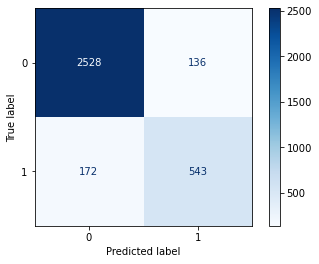

In [ ]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
print("***"*15)
print("Confusion Matrix")
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);


In [ ]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', accuracy_score(y_test,initial_lm_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.908849


The analysis of the confusion matrix points out some interesting aspects:
  
 - We have an accuracy close to 90%, which seems a good result to be reported to the HR department.
 
 - We are better at predicting the negative class (a employee is NOT going to leave the company) than the positive class (an employee will leave the company).

## Exercise #1: Filtering Methods (FUNDAMENTAL)


We will rank the features according to their predictive power by applying the methodologies seen in class: the Chi Squared Independence test and the Information Gain.

### Chi-squared Selection
Making use of the [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function rank the features according to the Chi Squared value. 

Does it make sense to remove some features? If so, do it!

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Your code here

Train a new model using only the selected features and evaluate its performance

In [ ]:
# Your code here

## Exercise #2: Embedded (FUNDAMENTAL)

Finally, we will experiment with embedded methods. If you remember from class, these methods focused on applying a regularization penalty to the model complexity. Utilizing this regularization, you can force the model to reduce the attention that it is paying to less relevant features. 

### Ridge

We will start with Ridge (or L2) regularization.

For this exercise, we are going to make use of the Ridge Model in sklearn <https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification>.

In [ ]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
get_feature_importance(ridge_mod, X_train.columns)

,variable,coefficient
0,time_spend_company_cat_Very_High,0.000000
1,time_spend_company_cat_High,0.000000
3,number_project_cat_High,-0.780000
2,satisfaction_level_bin,-1.080000
5,number_project_cat_Medium,-1.390000
4,time_spend_company_cat_Low,-2.860000


Accuracy = 0.9213
*********************************************
Confusion Matrix


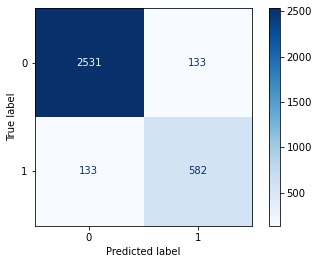

In [ ]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))
print("***"*15)
print("Confusion Matrix")
plot_confusion_matrix(ridge_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [ ]:
results_df.loc[len(results_df)] = ['LR Ridge', accuracy_score(y_test,ridge_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.908849
1,LR ChiSquared Selection,0.921278
2,LR Ridge,0.921278


Similar performance w.r.t the un-regularized models.

Let's look at how the coefficient weights and accuracy scores change along with the different regularization values.
To that end, I have implemented the following piece of code. Do not be overwhelmed by it. It basically defines a list of regularization values to test and train a new Logistic Regression model for one of these regularization values. We keep track of the coefficient values and the accuracy of each of these models to plot them according to the defined regularization parameters.

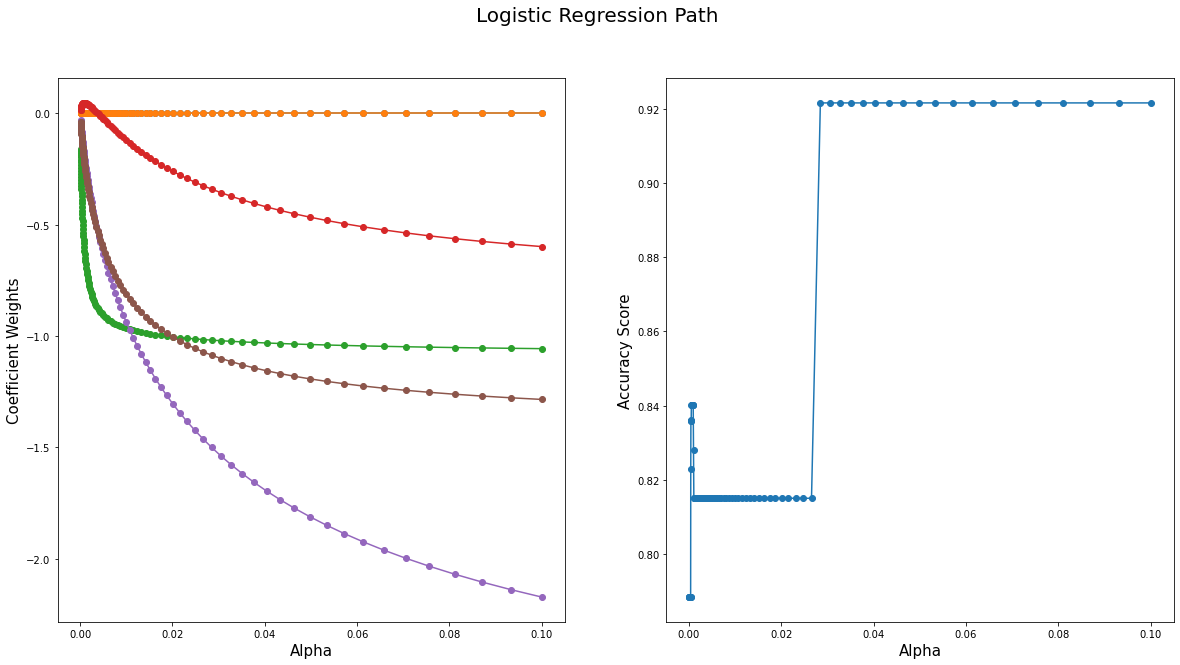

In [ ]:
# Define a basic Logisitic Regresion Model that applies L2 (Ridge) regularization
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')

# Define a list of 100 regularization values to test (from 0.1 to 0.0001)
alphas = 10**np.linspace(-1,-4,100)

coefs_ = [] # Array to store the value of the coefficients for each model
scores_ = [] # Array to store the accuracy for each model

# Go over the regularization values list defined above, train a logreg model for each of the regularization values and evaluate it.
for a in alphas:
    ridge_mod.set_params(C=a) # Set the regularization parameter 
    ridge_mod.fit(X_train, y_train) # Train the LogReg model
    coefs_.append(ridge_mod.coef_.ravel().copy()) # Appends the coefficient of the model
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test))) # Appends the accuracy of the model

# Conver the coefficient and scores arrays to numpy arrays
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

# Define the figures to plot the values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

As you can see in the left figure, the smaller the alpha value (alpha), the larger the regularization and, consequently, the smaller the weights of the coefficients. This is because, if we check the sklearn documentation, we will see that this value is the: "*Inverse of regularization strength*."

When regularization is large enough (i.e., alpha is small), the values of the coefficients are close to 0 (i.e., null model).

 As there is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), You must find the optimal alpha value. As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization). This specific value is not always the same since it depends on your data and the prediction problem. 

To automatize the process of finding the optimal value, you can make use of the LogisticRegressionCV function in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) that performs CV, testing different hyperparameters (that you can provide) and selecting the optimal one. 

In [ ]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.9216
*********************************************
Confusion Matrix


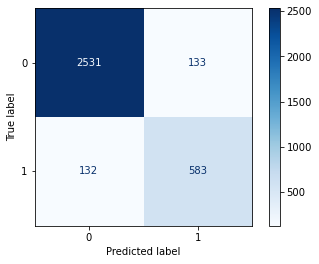

In [ ]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
print("***"*15)
print("Confusion Matrix")
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [ ]:
results_df.loc[len(results_df)] = ['LR CV Ridge', accuracy_score(y_test,ridge_mod_cv.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.908849
1,LR ChiSquared Selection,0.921278
2,LR Ridge,0.921278
3,LR CV Ridge,0.921574


We do not have many features, so the optimization of the alpha values does not provide a huge improvement. However, in scenarios with more complex datasets this procedure can significantly improve your model performance.

### Lasso

Repeat the same process than with Ridge to see if Lasso (which actually removes features by making their coefficients equal to 0) improves the unregularized model.

In [ ]:
# Your code here